# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, **HOG** should capture the texture of the image while ignoring
color information, and the **color histogram** represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` **functions** both operate on a single
image and return **a feature vector for that image**. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [31]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [34]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [2e4, 5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
iters = 1500
for lr in learning_rates:
    for reg in regularization_strengths:
        svm_t = LinearSVM()
        svm_t.train(X_train_feats, y_train, 
                    learning_rate=lr, reg=reg,
                    num_iters=iters, verbose=True)
        
        y_train_pred = svm_t.predict(X_train_feats)
        acc_train = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm_t.predict(X_val_feats)
        acc_val = np.mean(y_val == y_val_pred)
        
        # 给字典赋值
        results[(lr, reg)] = (acc_train, acc_val)

        if best_val < acc_val:
            best_val = acc_val
            best_svm = svm_t
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 24.487385
iteration 100 / 1500: loss 24.406908
iteration 200 / 1500: loss 24.334081
iteration 300 / 1500: loss 24.293748
iteration 400 / 1500: loss 24.225012
iteration 500 / 1500: loss 24.180415
iteration 600 / 1500: loss 24.114015
iteration 700 / 1500: loss 24.046515
iteration 800 / 1500: loss 23.987214
iteration 900 / 1500: loss 23.917035
iteration 1000 / 1500: loss 23.868347
iteration 1100 / 1500: loss 23.798697
iteration 1200 / 1500: loss 23.761148
iteration 1300 / 1500: loss 23.690553
iteration 1400 / 1500: loss 23.641300
iteration 0 / 1500: loss 48.741529
iteration 100 / 1500: loss 48.354611
iteration 200 / 1500: loss 47.967755
iteration 300 / 1500: loss 47.585981
iteration 400 / 1500: loss 47.187174
iteration 500 / 1500: loss 46.806361
iteration 600 / 1500: loss 46.437837
iteration 700 / 1500: loss 46.065489
iteration 800 / 1500: loss 45.694562
iteration 900 / 1500: loss 45.319248
iteration 1000 / 1500: loss 44.966395
iteration 1100 / 1500: loss 44.63312

In [35]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.411


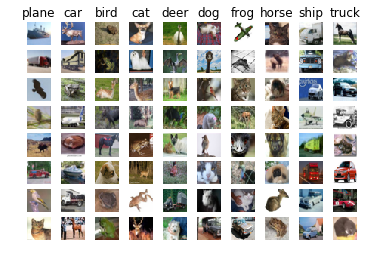

In [37]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

**Answer:**
图像的物体轮廓和错分的类的物体轮廓相似或是颜色相近。

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [38]:
print(X_train_feats.shape)

(49000, 155)


In [44]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
num_classes = 10
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
val_best = 0.0
results = {}
hidden_sizes = [50, 100, 150, 200, 500]
learning_rates = [1e-4, 2e-4, 1e-3, 2e-3, 1e-1, 5e-1]
regs = [1e-3, 2e-3, 3e-3]

for lr in learning_rates:
    for reg in regs:
        for hs in hidden_sizes:
            # Train the network
            net = TwoLayerNet(input_dim, hs, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                        num_iters=3000, batch_size=128,
                        learning_rate=lr, learning_rate_decay=0.995,
                        reg=reg, verbose=True)

            # Predict on the validation set
            val_acc = (net.predict(X_val_feats) == y_val).mean()

            results[(lr, reg, hs)] = val_acc
            
            if val_acc > val_best:
                val_best = val_acc
                best_net = net

for lr, reg, hs in sorted(results):
    val_acc = results[(lr, reg, hs)]
    print('lr %e  reg %e  hs %d  val accuracy: %f' % (lr, reg, hs, val_acc))

print("The best validation accuracu achieved during cross-validation: %f" % val_best)                
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.302588
iteration 200 / 3000: loss 2.302581
iteration 300 / 3000: loss 2.302585
iteration 400 / 3000: loss 2.302581
iteration 500 / 3000: loss 2.302577
iteration 600 / 3000: loss 2.302582
iteration 700 / 3000: loss 2.302593
iteration 800 / 3000: loss 2.302591
iteration 900 / 3000: loss 2.302587
iteration 1000 / 3000: loss 2.302576
iteration 1100 / 3000: loss 2.302586
iteration 1200 / 3000: loss 2.302591
iteration 1300 / 3000: loss 2.302585
iteration 1400 / 3000: loss 2.302574
iteration 1500 / 3000: loss 2.302576
iteration 1600 / 3000: loss 2.302592
iteration 1700 / 3000: loss 2.302596
iteration 1800 / 3000: loss 2.302590
iteration 1900 / 3000: loss 2.302606
iteration 2000 / 3000: loss 2.302595
iteration 2100 / 3000: loss 2.302574
iteration 2200 / 3000: loss 2.302577
iteration 2300 / 3000: loss 2.302585
iteration 2400 / 3000: loss 2.302582
iteration 2500 / 3000: loss 2.302602
iteration 2600 / 3000: loss 2.302579
iteration 270

iteration 1600 / 3000: loss 2.302573
iteration 1700 / 3000: loss 2.302593
iteration 1800 / 3000: loss 2.302595
iteration 1900 / 3000: loss 2.302587
iteration 2000 / 3000: loss 2.302576
iteration 2100 / 3000: loss 2.302564
iteration 2200 / 3000: loss 2.302585
iteration 2300 / 3000: loss 2.302569
iteration 2400 / 3000: loss 2.302585
iteration 2500 / 3000: loss 2.302600
iteration 2600 / 3000: loss 2.302600
iteration 2700 / 3000: loss 2.302593
iteration 2800 / 3000: loss 2.302582
iteration 2900 / 3000: loss 2.302575
iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.302584
iteration 200 / 3000: loss 2.302585
iteration 300 / 3000: loss 2.302588
iteration 400 / 3000: loss 2.302581
iteration 500 / 3000: loss 2.302583
iteration 600 / 3000: loss 2.302590
iteration 700 / 3000: loss 2.302587
iteration 800 / 3000: loss 2.302579
iteration 900 / 3000: loss 2.302584
iteration 1000 / 3000: loss 2.302594
iteration 1100 / 3000: loss 2.302595
iteration 1200 / 3000: loss 2.302580
iteration 130

iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.302590
iteration 200 / 3000: loss 2.302577
iteration 300 / 3000: loss 2.302593
iteration 400 / 3000: loss 2.302587
iteration 500 / 3000: loss 2.302580
iteration 600 / 3000: loss 2.302591
iteration 700 / 3000: loss 2.302588
iteration 800 / 3000: loss 2.302590
iteration 900 / 3000: loss 2.302592
iteration 1000 / 3000: loss 2.302581
iteration 1100 / 3000: loss 2.302564
iteration 1200 / 3000: loss 2.302602
iteration 1300 / 3000: loss 2.302575
iteration 1400 / 3000: loss 2.302574
iteration 1500 / 3000: loss 2.302580
iteration 1600 / 3000: loss 2.302615
iteration 1700 / 3000: loss 2.302606
iteration 1800 / 3000: loss 2.302610
iteration 1900 / 3000: loss 2.302582
iteration 2000 / 3000: loss 2.302542
iteration 2100 / 3000: loss 2.302611
iteration 2200 / 3000: loss 2.302600
iteration 2300 / 3000: loss 2.302593
iteration 2400 / 3000: loss 2.302622
iteration 2500 / 3000: loss 2.302607
iteration 2600 / 3000: loss 2.302642
iteration 270

iteration 1500 / 3000: loss 2.302564
iteration 1600 / 3000: loss 2.302582
iteration 1700 / 3000: loss 2.302574
iteration 1800 / 3000: loss 2.302585
iteration 1900 / 3000: loss 2.302554
iteration 2000 / 3000: loss 2.302597
iteration 2100 / 3000: loss 2.302594
iteration 2200 / 3000: loss 2.302536
iteration 2300 / 3000: loss 2.302539
iteration 2400 / 3000: loss 2.302577
iteration 2500 / 3000: loss 2.302618
iteration 2600 / 3000: loss 2.302608
iteration 2700 / 3000: loss 2.302537
iteration 2800 / 3000: loss 2.302608
iteration 2900 / 3000: loss 2.302581
iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.302583
iteration 200 / 3000: loss 2.302587
iteration 300 / 3000: loss 2.302589
iteration 400 / 3000: loss 2.302593
iteration 500 / 3000: loss 2.302590
iteration 600 / 3000: loss 2.302566
iteration 700 / 3000: loss 2.302588
iteration 800 / 3000: loss 2.302588
iteration 900 / 3000: loss 2.302604
iteration 1000 / 3000: loss 2.302598
iteration 1100 / 3000: loss 2.302594
iteration 120

iteration 2900 / 3000: loss 2.302583
iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.302559
iteration 200 / 3000: loss 2.302628
iteration 300 / 3000: loss 2.302712
iteration 400 / 3000: loss 2.302660
iteration 500 / 3000: loss 2.302712
iteration 600 / 3000: loss 2.302535
iteration 700 / 3000: loss 2.302645
iteration 800 / 3000: loss 2.302525
iteration 900 / 3000: loss 2.302481
iteration 1000 / 3000: loss 2.302616
iteration 1100 / 3000: loss 2.302495
iteration 1200 / 3000: loss 2.302831
iteration 1300 / 3000: loss 2.302760
iteration 1400 / 3000: loss 2.302382
iteration 1500 / 3000: loss 2.302755
iteration 1600 / 3000: loss 2.302519
iteration 1700 / 3000: loss 2.302329
iteration 1800 / 3000: loss 2.302574
iteration 1900 / 3000: loss 2.302461
iteration 2000 / 3000: loss 2.302510
iteration 2100 / 3000: loss 2.302698
iteration 2200 / 3000: loss 2.302519
iteration 2300 / 3000: loss 2.302645
iteration 2400 / 3000: loss 2.302606
iteration 2500 / 3000: loss 2.302747
iteration 260

iteration 1500 / 3000: loss 2.302442
iteration 1600 / 3000: loss 2.302677
iteration 1700 / 3000: loss 2.302670
iteration 1800 / 3000: loss 2.302484
iteration 1900 / 3000: loss 2.302530
iteration 2000 / 3000: loss 2.302601
iteration 2100 / 3000: loss 2.302492
iteration 2200 / 3000: loss 2.302438
iteration 2300 / 3000: loss 2.302654
iteration 2400 / 3000: loss 2.302639
iteration 2500 / 3000: loss 2.302551
iteration 2600 / 3000: loss 2.302230
iteration 2700 / 3000: loss 2.302628
iteration 2800 / 3000: loss 2.302272
iteration 2900 / 3000: loss 2.302684
iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.302580
iteration 200 / 3000: loss 2.302617
iteration 300 / 3000: loss 2.302575
iteration 400 / 3000: loss 2.302521
iteration 500 / 3000: loss 2.302579
iteration 600 / 3000: loss 2.302594
iteration 700 / 3000: loss 2.302507
iteration 800 / 3000: loss 2.302645
iteration 900 / 3000: loss 2.302594
iteration 1000 / 3000: loss 2.302690
iteration 1100 / 3000: loss 2.302652
iteration 120

iteration 2900 / 3000: loss 2.302366
iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.302707
iteration 200 / 3000: loss 2.302572
iteration 300 / 3000: loss 2.302595
iteration 400 / 3000: loss 2.302659
iteration 500 / 3000: loss 2.302687
iteration 600 / 3000: loss 2.302600
iteration 700 / 3000: loss 2.302387
iteration 800 / 3000: loss 2.302771
iteration 900 / 3000: loss 2.302483
iteration 1000 / 3000: loss 2.302521
iteration 1100 / 3000: loss 2.302631
iteration 1200 / 3000: loss 2.302803
iteration 1300 / 3000: loss 2.302448
iteration 1400 / 3000: loss 2.303087
iteration 1500 / 3000: loss 2.302288
iteration 1600 / 3000: loss 2.302742
iteration 1700 / 3000: loss 2.302967
iteration 1800 / 3000: loss 2.302947
iteration 1900 / 3000: loss 2.302652
iteration 2000 / 3000: loss 2.302769
iteration 2100 / 3000: loss 2.302577
iteration 2200 / 3000: loss 2.302917
iteration 2300 / 3000: loss 2.302663
iteration 2400 / 3000: loss 2.302567
iteration 2500 / 3000: loss 2.302288
iteration 260

iteration 1500 / 3000: loss 2.302753
iteration 1600 / 3000: loss 2.302510
iteration 1700 / 3000: loss 2.302677
iteration 1800 / 3000: loss 2.302452
iteration 1900 / 3000: loss 2.302279
iteration 2000 / 3000: loss 2.302608
iteration 2100 / 3000: loss 2.302629
iteration 2200 / 3000: loss 2.302320
iteration 2300 / 3000: loss 2.302707
iteration 2400 / 3000: loss 2.302520
iteration 2500 / 3000: loss 2.302666
iteration 2600 / 3000: loss 2.302526
iteration 2700 / 3000: loss 2.302475
iteration 2800 / 3000: loss 2.302518
iteration 2900 / 3000: loss 2.302385
iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.302629
iteration 200 / 3000: loss 2.302466
iteration 300 / 3000: loss 2.302635
iteration 400 / 3000: loss 2.302702
iteration 500 / 3000: loss 2.302511
iteration 600 / 3000: loss 2.302628
iteration 700 / 3000: loss 2.302543
iteration 800 / 3000: loss 2.302598
iteration 900 / 3000: loss 2.302456
iteration 1000 / 3000: loss 2.302497
iteration 1100 / 3000: loss 2.302647
iteration 120

iteration 2900 / 3000: loss 2.302494
iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.305189
iteration 200 / 3000: loss 2.146243
iteration 300 / 3000: loss 1.863982
iteration 400 / 3000: loss 1.727908
iteration 500 / 3000: loss 1.492923
iteration 600 / 3000: loss 1.493171
iteration 700 / 3000: loss 1.571917
iteration 800 / 3000: loss 1.562771
iteration 900 / 3000: loss 1.540909
iteration 1000 / 3000: loss 1.430226
iteration 1100 / 3000: loss 1.704190
iteration 1200 / 3000: loss 1.246600
iteration 1300 / 3000: loss 1.408586
iteration 1400 / 3000: loss 1.243232
iteration 1500 / 3000: loss 1.344005
iteration 1600 / 3000: loss 1.370338
iteration 1700 / 3000: loss 1.291599
iteration 1800 / 3000: loss 1.440783
iteration 1900 / 3000: loss 1.249445
iteration 2000 / 3000: loss 1.311628
iteration 2100 / 3000: loss 1.216245
iteration 2200 / 3000: loss 1.229547
iteration 2300 / 3000: loss 1.149671
iteration 2400 / 3000: loss 1.392240
iteration 2500 / 3000: loss 1.356121
iteration 260

iteration 1500 / 3000: loss 1.404733
iteration 1600 / 3000: loss 1.471549
iteration 1700 / 3000: loss 1.239645
iteration 1800 / 3000: loss 1.310955
iteration 1900 / 3000: loss 1.258605
iteration 2000 / 3000: loss 1.282576
iteration 2100 / 3000: loss 1.296130
iteration 2200 / 3000: loss 1.429720
iteration 2300 / 3000: loss 1.202693
iteration 2400 / 3000: loss 1.110223
iteration 2500 / 3000: loss 1.301623
iteration 2600 / 3000: loss 1.211862
iteration 2700 / 3000: loss 1.275963
iteration 2800 / 3000: loss 1.141679
iteration 2900 / 3000: loss 1.468458
iteration 0 / 3000: loss 2.302586
iteration 100 / 3000: loss 2.302906
iteration 200 / 3000: loss 2.139562
iteration 300 / 3000: loss 1.845058
iteration 400 / 3000: loss 1.735220
iteration 500 / 3000: loss 1.449717
iteration 600 / 3000: loss 1.602437
iteration 700 / 3000: loss 1.438767
iteration 800 / 3000: loss 1.371111
iteration 900 / 3000: loss 1.414064
iteration 1000 / 3000: loss 1.435774
iteration 1100 / 3000: loss 1.330544
iteration 120

iteration 2900 / 3000: loss 1.162196
iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 1.698853
iteration 200 / 3000: loss 1.369713
iteration 300 / 3000: loss 1.584550
iteration 400 / 3000: loss 1.305324
iteration 500 / 3000: loss 1.427201
iteration 600 / 3000: loss 1.163278
iteration 700 / 3000: loss 1.363412
iteration 800 / 3000: loss 1.391322
iteration 900 / 3000: loss 1.358023
iteration 1000 / 3000: loss 1.300065
iteration 1100 / 3000: loss 1.338533
iteration 1200 / 3000: loss 1.147527
iteration 1300 / 3000: loss 1.218710
iteration 1400 / 3000: loss 1.336719
iteration 1500 / 3000: loss 1.135045
iteration 1600 / 3000: loss 1.220509
iteration 1700 / 3000: loss 1.312465
iteration 1800 / 3000: loss 1.427027
iteration 1900 / 3000: loss 1.167409
iteration 2000 / 3000: loss 1.422079
iteration 2100 / 3000: loss 1.314751
iteration 2200 / 3000: loss 1.339414
iteration 2300 / 3000: loss 1.175879
iteration 2400 / 3000: loss 1.311497
iteration 2500 / 3000: loss 1.225555
iteration 260

iteration 1500 / 3000: loss 1.267683
iteration 1600 / 3000: loss 1.261784
iteration 1700 / 3000: loss 1.431269
iteration 1800 / 3000: loss 1.298089
iteration 1900 / 3000: loss 1.312086
iteration 2000 / 3000: loss 1.314526
iteration 2100 / 3000: loss 1.513206
iteration 2200 / 3000: loss 1.268003
iteration 2300 / 3000: loss 1.577814
iteration 2400 / 3000: loss 1.171344
iteration 2500 / 3000: loss 1.366720
iteration 2600 / 3000: loss 1.384674
iteration 2700 / 3000: loss 1.086793
iteration 2800 / 3000: loss 1.274497
iteration 2900 / 3000: loss 1.196735
iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 1.501945
iteration 200 / 3000: loss 1.434883
iteration 300 / 3000: loss 1.389501
iteration 400 / 3000: loss 1.373154
iteration 500 / 3000: loss 1.328172
iteration 600 / 3000: loss 1.456896
iteration 700 / 3000: loss 1.333722
iteration 800 / 3000: loss 1.448421
iteration 900 / 3000: loss 1.356643
iteration 1000 / 3000: loss 1.264709
iteration 1100 / 3000: loss 1.270156
iteration 120

iteration 2900 / 3000: loss 1.163799
lr 1.000000e-04  reg 1.000000e-03  hs 50  val accuracy: 0.098000
lr 1.000000e-04  reg 1.000000e-03  hs 100  val accuracy: 0.112000
lr 1.000000e-04  reg 1.000000e-03  hs 150  val accuracy: 0.105000
lr 1.000000e-04  reg 1.000000e-03  hs 200  val accuracy: 0.078000
lr 1.000000e-04  reg 1.000000e-03  hs 500  val accuracy: 0.087000
lr 1.000000e-04  reg 2.000000e-03  hs 50  val accuracy: 0.079000
lr 1.000000e-04  reg 2.000000e-03  hs 100  val accuracy: 0.079000
lr 1.000000e-04  reg 2.000000e-03  hs 150  val accuracy: 0.112000
lr 1.000000e-04  reg 2.000000e-03  hs 200  val accuracy: 0.107000
lr 1.000000e-04  reg 2.000000e-03  hs 500  val accuracy: 0.078000
lr 1.000000e-04  reg 3.000000e-03  hs 50  val accuracy: 0.087000
lr 1.000000e-04  reg 3.000000e-03  hs 100  val accuracy: 0.119000
lr 1.000000e-04  reg 3.000000e-03  hs 150  val accuracy: 0.078000
lr 1.000000e-04  reg 3.000000e-03  hs 200  val accuracy: 0.087000
lr 1.000000e-04  reg 3.000000e-03  hs 500 

In [45]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.552


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!